# Transforms and Resampling

本笔记本介绍了如何将变换应用于图像，以及如何执行图像重采样。

In [1]:
from __future__ import print_function
import SimpleITK as sitk
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from ipywidgets import interact, fixed

# Utility method that either downloads data from the Girder repository or
# if already downloaded returns the file name for reading from disk (cached data).
%run update_path_to_download_script
from downloaddata import fetch_data as fdata

## Creating and Manipulating Transforms

SimpleITK提供了许多不同的空间变换。 最简单的是**恒等变换(Identity Transform)。** 

此转换仅返回未改变的输入点。

```
identity = sitk.Transform(dimension, sitk.sitkIdentity)
```

In [2]:
dimension = 2

print('*Identity Transform*')
identity = sitk.Transform(dimension, sitk.sitkIdentity)
print('Dimension: ' + str(identity.GetDimension()))

# Points are always defined in physical space
point = (1.0, 1.0)
def transform_point(transform, point):
    transformed_point = transform.TransformPoint(point)
    print('Point ' + str(point) + ' transformed is ' + str(transformed_point))

transform_point(identity, point)

*Identity Transform*
Dimension: 2
Point (1.0, 1.0) transformed is (1.0, 1.0)


变换由两组参数定义，即**Parameters**和 **FixedParameters**。 在执行注册时，在优化过程中不会更改**FixedParameters**。 对于TranslationTransform，Parameters是平移的偏移量。

In [4]:
print('*Translation Transform*')
translation = sitk.TranslationTransform(dimension)

print('Parameters: ' + str(translation.GetParameters()))
print('Offset:     ' + str(translation.GetOffset()))
print('FixedParameters: ' + str(translation.GetFixedParameters()))
transform_point(translation, point)

print('')
#设置Parameters，即设置平移的偏移量
translation.SetParameters((3.1, 4.4))
print('Parameters: ' + str(translation.GetParameters()))
transform_point(translation, point)

*Translation Transform*
Parameters: (0.0, 0.0)
Offset:     (0.0, 0.0)
FixedParameters: ()
Point (1.0, 1.0) transformed is (1.0, 1.0)

Parameters: (3.1, 4.4)
Point (1.0, 1.0) transformed is (4.1, 5.4)


仿射变换(affine transform)能够表示平移(translations)，旋转(rotations)，剪切(shearing)和缩放(scaling)。

In [5]:
print('*Affine Transform*')
affine = sitk.AffineTransform(dimension)

print('Parameters: ' + str(affine.GetParameters()))
print('FixedParameters: ' + str(affine.GetFixedParameters()))
transform_point(affine, point)

print('')
affine.SetTranslation((3.1, 4.4))
print('Parameters: ' + str(affine.GetParameters()))
transform_point(affine, point)

*Affine Transform*
Parameters: (1.0, 0.0, 0.0, 1.0, 0.0, 0.0)
FixedParameters: (0.0, 0.0)
Point (1.0, 1.0) transformed is (1.0, 1.0)

Parameters: (1.0, 0.0, 0.0, 1.0, 3.1, 4.4)
Point (1.0, 1.0) transformed is (4.1, 5.4)


存在许多其他变换来表示非仿射变形，在3D中表现良好的旋转等。有关更多信息，请参阅[Transforms](22_Transforms.ipynb)。

## Applying Transforms to Images

创建一个函数来显示知道图像间距的图像。

In [6]:
def myshow(img, title=None, margin=0.05, dpi=80):
    nda = sitk.GetArrayViewFromImage(img)
    spacing = img.GetSpacing()
        
    ysize = nda.shape[0]
    xsize = nda.shape[1]
      
    figsize = (1 + margin) * ysize / dpi, (1 + margin) * xsize / dpi

    fig = plt.figure(title, figsize=figsize, dpi=dpi)
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])
    
    extent = (0, xsize*spacing[1], 0, ysize*spacing[0])
    
    t = ax.imshow(nda,
            extent=extent,
            interpolation='hamming',
            cmap='gray',
            origin='lower')
    
    if(title):
        plt.title(title)

创建一个网格图像

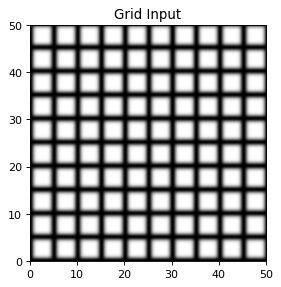

In [7]:
grid = sitk.GridSource(outputPixelType=sitk.sitkUInt16,
    size=(250, 250),
    sigma=(0.5, 0.5),
    gridSpacing=(5.0, 5.0),
    gridOffset=(0.0, 0.0),
    spacing=(0.2,0.2))
myshow(grid, 'Grid Input')

要应用转换，需要重采样操作。

Point (1.0, 1.0) transformed is (4.1, 5.6)


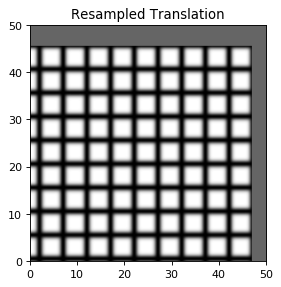

In [8]:
def resample(image, transform):
    # 输出图像的Origin, Spacing, Size, Direction由Resample函数指定的参考图像设定
    reference_image = image
    interpolator = sitk.sitkCosineWindowedSinc
    default_value = 100.0
    return sitk.Resample(image, reference_image, transform,
                         interpolator, default_value)
translation = sitk.TranslationTransform(dimension)
translation.SetOffset((3.1, 4.6))
transform_point(translation, point)
resampled = resample(grid, translation)
myshow(resampled, 'Resampled Translation')

发生了什么？ 平移在两个方向都是正向的。 为什么输出图像向下移动到左边？ 重要的是要记住，重采样操作中的变换定义了**从输出空间到输入空间的变换。**

Point (1.0, 1.0) transformed is (-2.1, -3.5999999999999996)


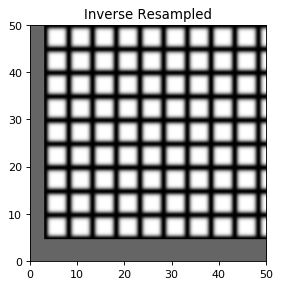

In [9]:
translation.SetOffset(-1*np.array(translation.GetParameters()))
transform_point(translation, point)
resampled = resample(grid, translation)
myshow(resampled, 'Inverse Resampled')

### 仿射变换，可以实现平移：

- **平移变换的正方向:左下**
1. new_transform = sitk.AffineTransform(dimension)
2. new_transform.SetTranslation((x_translation=3.1, y_translation=4.6))
3. image_resampled = sitk.Resample(image, reference_image, transform,interpolator, default_value)

In [19]:
def affine_translate(transform, x_translation=3.1, y_translation=4.6):
    new_transform=transform
    new_transform = sitk.AffineTransform(transform)
    new_transform.SetTranslation((x_translation, y_translation))
    resampled = resample(grid, new_transform)
    myshow(resampled, 'Translated')
    return new_transform
    
affine = sitk.AffineTransform(dimension)

interact(affine_translate, transform=fixed(affine), x_translation=(-5.0, 5.0), y_translation=(-5.0, 5.0))

interactive(children=(FloatSlider(value=3.1, description='x_translation', max=5.0, min=-5.0), FloatSlider(valu…

<function __main__.affine_translate(transform, x_translation=3.1, y_translation=4.6)>

### 仿射变换，可以实现放缩：
1. new_transform = sitk.AffineTransform(dimension)
2. **matrix = np.array(transform.GetMatrix()).reshape((dimension,dimension))**
3. **matrix[0,0] = x_scale,matrix[1,1] = y_scale**
4. new_transform.SetMatrix(matrix.ravel())
5. image_resampled = resample(image, new_transform)

In [15]:
def affine_scale(transform, x_scale=3.0, y_scale=0.7):
    '''
    x_scale=3.0：x_output*3.0=x_input==>x_output=x_input/3.0
    y_scale=0.7: y_output*0.7=y_input==>y_output=y_input/0.7
    '''
    new_transform = sitk.AffineTransform(transform)
    matrix = np.array(transform.GetMatrix()).reshape((dimension,dimension))
    matrix[0,0] = x_scale
    matrix[1,1] = y_scale
    new_transform.SetMatrix(matrix.ravel())
    resampled = resample(grid, new_transform)
    myshow(resampled, 'Scaled')
    print(matrix)
    return new_transform

affine = sitk.AffineTransform(dimension)

interact(affine_scale, transform=fixed(affine), x_scale=(0.2, 5.0), y_scale=(0.2, 5.0))

interactive(children=(FloatSlider(value=3.0, description='x_scale', max=5.0, min=0.2), FloatSlider(value=0.7, …

<function __main__.affine_scale(transform, x_scale=3.0, y_scale=0.7)>

### 仿射变换，可以实现旋转：
1. new_transform = sitk.AffineTransform(dimension)
2. **matrix = np.array(transform.GetMatrix()).reshape((dimension,dimension))**
3. radians = -np.pi * degrees / 180.
4. rotation = np.array([[np.cos(radians), -np.sin(radians)],[np.sin(radians), np.cos(radians)]])
5. new_matrix = np.dot(rotation, matrix)
6. new_transform.SetMatrix(new_matrix.ravel())
7. image_resampled = resample(image, new_transform)

In [16]:
def affine_rotate(transform, degrees=15.0):
    parameters = np.array(transform.GetParameters())
    new_transform = sitk.AffineTransform(transform)
    matrix = np.array(transform.GetMatrix()).reshape((dimension,dimension))
    print("paramters_old:{}".format(parameters))
    print("matrix_old:{}".format(matrix))
    
    #角度转弧度,
    radians = -np.pi * degrees / 180.
    rotation = np.array([[np.cos(radians), -np.sin(radians)],[np.sin(radians), np.cos(radians)]])
    new_matrix = np.dot(rotation, matrix)
    new_transform.SetMatrix(new_matrix.ravel())
    resampled = resample(grid, new_transform)
    print("paramters_new:{}".format(parameters))
    print("matrix_new:{}".format(new_matrix))
    myshow(resampled, 'Rotated')
    return new_transform
    
affine = sitk.AffineTransform(dimension)

interact(affine_rotate, transform=fixed(affine), degrees=(-90.0, 90.0))

interactive(children=(FloatSlider(value=15.0, description='degrees', max=90.0, min=-90.0), Output()), _dom_cla…

<function __main__.affine_rotate(transform, degrees=15.0)>

### 仿射变换，可以实现剪切：
1. new_transform = sitk.AffineTransform(dimension)
2. **matrix = np.array(transform.GetMatrix()).reshape((dimension,dimension))**
3. **matrix[0,1] = -x_shear，matrix[1,0] = -y_shear**
4. new_matrix = np.dot(rotation, matrix)
5. new_transform.SetMatrix(new_matrix.ravel())
6. image_resampled = resample(image, new_transform)

In [17]:
def affine_shear(transform, x_shear=0.3, y_shear=0.1):
    new_transform = sitk.AffineTransform(transform)
    matrix = np.array(transform.GetMatrix()).reshape((dimension,dimension))
    matrix[0,1] = -x_shear
    matrix[1,0] = -y_shear
    new_transform.SetMatrix(matrix.ravel())
    resampled = resample(grid, new_transform)
    myshow(resampled, 'Sheared')
    print(matrix)
    return new_transform

affine = sitk.AffineTransform(dimension)

interact(affine_shear, transform=fixed(affine), x_shear=(0.1, 2.0), y_shear=(0.1, 2.0))

interactive(children=(FloatSlider(value=0.3, description='x_shear', max=2.0, min=0.1), FloatSlider(value=0.1, …

<function __main__.affine_shear(transform, x_shear=0.3, y_shear=0.1)>

## Composite Transform

可以将多个变换组合成一个变换对象。 通过复合变换，可以防止多次重采样操作，因此不会累积插值误差。 例如，由平移和旋转组成的仿射变换，

也可以使用复合变换按顺序应用两个Transform对象来表示，
1. composite = sitk.Transform(dimension, sitk.sitkComposite)
2. translation = sitk.TranslationTransform(dimension),........
3. affine_rot = sitk.AffineTransform(dimension),.......
4. composite.AddTransform(translation)
5. composite.AddTransform(affine)

paramters_old:[1. 0. 0. 1. 0. 0.]
matrix_old:[[1. 0.]
 [0. 1.]]
paramters_new:[1. 0. 0. 1. 0. 0.]
matrix_new:[[ 0.93969262  0.34202014]
 [-0.34202014  0.93969262]]


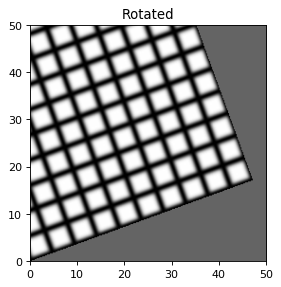

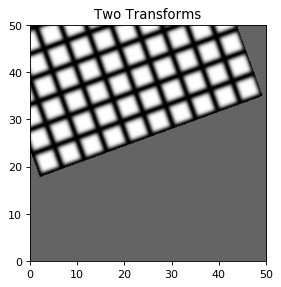

In [29]:
composite = sitk.Transform(dimension, sitk.sitkComposite)
translation = sitk.TranslationTransform(dimension)
translation.SetOffset(-1*np.array(translate))

affine_rot = sitk.AffineTransform(dimension)
affinerot_ = affine_rotate(affine, rotate)
composite.AddTransform(translation)
composite.AddTransform(affine)

resampled = resample(grid, composite)
myshow(resampled, 'Two Transforms')

**注意**，转换是非交换的 - 顺序很重要！

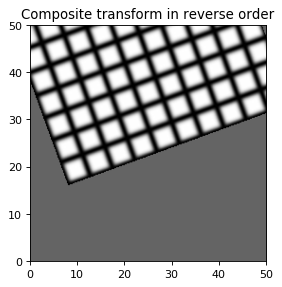

In [30]:
composite = sitk.Transform(dimension, sitk.sitkComposite)
composite.AddTransform(affine)
composite.AddTransform(translation)

resampled = resample(grid, composite)
myshow(resampled, 'Composite transform in reverse order')

## Resampling

<img src="resampling.svg"/><br><br>

重采样作为动词表示是对图像进行采样的动作，图像本身是原始连续信号的采样。

一般来说，SimpleITK中的重新采样涉及四个组件：

- Image - 我们重新采样的图像，以坐标系$m$给出。
- Resampling grid - 坐标系$f$中给出的规则网格点，将映射到坐标系$m$,**输出空间网输入空间映射**。
- Transformation $T_f^m$  - 将坐标系$f$中的点映射到坐标系$m$，$^mp = T_f^m(^fp)$。
- Interpolator - 从图像定义的点的值获得坐标系$m$中任意点的强度值的方法。

虽然SimpleITK提供了大量的插值方法，但最常用的两种方法是``sitkLinear``和``sitkNearestNeighbor``。前者用于大多数插值任务，精度和计算效率之间的折衷。**后者用于内插表示分割的标记图像，它是唯一不会在结果中引入新标签的插值方法。**

SimpleITK的过程API提供了三种执行重新采样的方法，区别在于您指定重采样网格的方式：

1. ```Resample(const Image &image1, Transform transform, InterpolatorEnum interpolator, double defaultPixelValue, PixelIDValueEnum outputPixelType)```
2. ```Resample(const Image &image1, const Image &referenceImage, Transform transform, InterpolatorEnum interpolator, double defaultPixelValue, PixelIDValueEnum outputPixelType)```
3. ```Resample(const Image &image1, std::vector< uint32_t > size, Transform transform, InterpolatorEnum interpolator, std::vector< double > outputOrigin, std::vector< double > outputSpacing, std::vector< double > outputDirection, double defaultPixelValue, PixelIDValueEnum outputPixelType)```

In [32]:
def resample_display(image, euler2d_transform, tx, ty, theta):
    euler2d_transform.SetTranslation((tx, ty))
    euler2d_transform.SetAngle(theta)
    
    resampled_image = sitk.Resample(image, euler2d_transform)
    plt.imshow(sitk.GetArrayFromImage(resampled_image))
    plt.axis('off')    
    plt.show()

logo = sitk.ReadImage(fdata('SimpleITK.jpg'))

euler2d = sitk.Euler2DTransform()
# Why do we set the center?
euler2d.SetCenter(logo.TransformContinuousIndexToPhysicalPoint(np.array(logo.GetSize())/2.0))
interact(resample_display, image=fixed(logo), euler2d_transform=fixed(euler2d), tx=(-128.0, 128.0,2.5), ty=(-64.0, 64.0), theta=(-np.pi/4.0,np.pi/4.0));

Fetching SimpleITK.jpg


interactive(children=(FloatSlider(value=-0.5, description='tx', max=128.0, min=-128.0, step=2.5), FloatSlider(…

### Common Errors
重采样后最终得到一个空的（全黑）图像并不罕见。 这是由于：
1. 对重采样网格使用了错误的设置，不太常见，但确实发生了。 
2. 使用变换$T_f^m$的逆变换。 这是一个相对常见的错误，可以通过调用转换``GetInverse``方法轻松解决。

### Defining the Resampling Grid
在上面的示例中，我们任意使用原始图像网格作为resampling grid。结果，对于许多变换，所得到的图像包含黑色像素，映射到原始图像的空间域之外的像素和原始图像的局部视图。

如果我们希望无论使用何种transformation，生成的图像包含所有原始图像，我们将需要使用我们对原始图像的空间域和**给定transformation的逆**的知识来定义重采样网格。

在处理仿射变换时计算resampling grid的边界是直截了当的。仿射变换保留了具有映射到极值点的极值点的凸性。因此，我们只需要将**逆变换**应用于原始图像的角点以获得resampling grid的边界。

**在处理BSplineTransform或DisplacementFieldTransform时计算重采样网格的边界更为复杂，因为我们无法保证极值点被映射到极值点。这要求我们将逆变换应用于原始图像中的所有点以获得重采样网格的边界。**

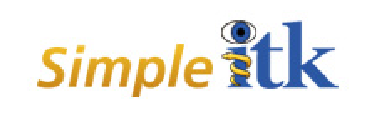

In [33]:
euler2d = sitk.Euler2DTransform()
# Why do we set the center?
euler2d.SetCenter(logo.TransformContinuousIndexToPhysicalPoint(np.array(logo.GetSize())/2.0))

tx = 64
ty = 32
euler2d.SetTranslation((tx, ty))

extreme_points = [logo.TransformIndexToPhysicalPoint((0,0)), 
                  logo.TransformIndexToPhysicalPoint((logo.GetWidth(),0)),
                  logo.TransformIndexToPhysicalPoint((logo.GetWidth(),logo.GetHeight())),
                  logo.TransformIndexToPhysicalPoint((0,logo.GetHeight()))]
#逆变换
inv_euler2d = euler2d.GetInverse()

extreme_points_transformed = [inv_euler2d.TransformPoint(pnt) for pnt in extreme_points]
min_x = min(extreme_points_transformed)[0]
min_y = min(extreme_points_transformed, key=lambda p: p[1])[1]
max_x = max(extreme_points_transformed)[0]
max_y = max(extreme_points_transformed, key=lambda p: p[1])[1]

# Use the original spacing (arbitrary decision).
output_spacing = logo.GetSpacing()

# Identity cosine matrix (arbitrary decision).   
output_direction = [1.0, 0.0, 0.0, 1.0]

# Minimal x,y coordinates are the new origin.
output_origin = [min_x, min_y]

# Compute grid size based on the physical size and spacing.
output_size = [int((max_x-min_x)/output_spacing[0]), int((max_y-min_y)/output_spacing[1])]

resampled_image = sitk.Resample(logo, output_size, euler2d, sitk.sitkLinear, output_origin, output_spacing, output_direction)

plt.imshow(sitk.GetArrayViewFromImage(resampled_image))
plt.axis('off')    
plt.show()

你对结果感到困惑吗？ 输出只是输入的副本吗？ 在上面的代码中添加一个旋转，看看会发生什么(```euler2d.SetAngle(0.79)```)。

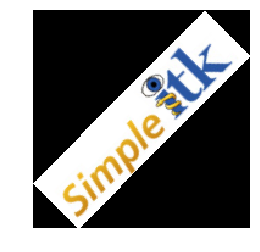

In [34]:
euler2d = sitk.Euler2DTransform()
# Why do we set the center?
euler2d.SetCenter(logo.TransformContinuousIndexToPhysicalPoint(np.array(logo.GetSize())/2.0))
euler2d.SetAngle(0.79)

tx = 64
ty = 32
euler2d.SetTranslation((tx, ty))

extreme_points = [logo.TransformIndexToPhysicalPoint((0,0)), 
                  logo.TransformIndexToPhysicalPoint((logo.GetWidth(),0)),
                  logo.TransformIndexToPhysicalPoint((logo.GetWidth(),logo.GetHeight())),
                  logo.TransformIndexToPhysicalPoint((0,logo.GetHeight()))]
#逆变换
inv_euler2d = euler2d.GetInverse()

extreme_points_transformed = [inv_euler2d.TransformPoint(pnt) for pnt in extreme_points]
min_x = min(extreme_points_transformed)[0]
min_y = min(extreme_points_transformed, key=lambda p: p[1])[1]
max_x = max(extreme_points_transformed)[0]
max_y = max(extreme_points_transformed, key=lambda p: p[1])[1]

# Use the original spacing (arbitrary decision).
output_spacing = logo.GetSpacing()

# Identity cosine matrix (arbitrary decision).   
output_direction = [1.0, 0.0, 0.0, 1.0]

# Minimal x,y coordinates are the new origin.
output_origin = [min_x, min_y]

# Compute grid size based on the physical size and spacing.
output_size = [int((max_x-min_x)/output_spacing[0]), int((max_y-min_y)/output_spacing[1])]

resampled_image = sitk.Resample(logo, output_size, euler2d, sitk.sitkLinear, output_origin, output_spacing, output_direction)

plt.imshow(sitk.GetArrayViewFromImage(resampled_image))
plt.axis('off')
plt.show()

### Resampling at a set of locations 
在某些情况下，您可能有兴趣获得一组点的强度值（例如，对从图像分割的网格模型的顶点着色）。

下面的代码在图像中生成随机点集，并重新采样这些位置的强度值。 它被设计能适用于所有图像尺寸和类型（标量或向量像素）。

In [35]:
img = logo

# Generate random samples inside the image, we will obtain the intensity/color values at these points.
num_samples = 10
physical_points = []
for pnt in zip(*[list(np.random.random(num_samples)*sz) for sz in img.GetSize()]):
    physical_points.append(img.TransformContinuousIndexToPhysicalPoint(pnt))

# Create an image of size [num_samples,1...1], actual size is dependent on the image dimensionality. The pixel
# type is irrelevant, as the image is just defining the interpolation grid (sitkUInt8 has minimal memory footprint).
interp_grid_img = sitk.Image([num_samples] + [1]*(img.GetDimension()-1), sitk.sitkUInt8)

# Define the displacement field transformation, maps the points in the interp_grid_img to the points in the actual
# image.
displacement_img = sitk.Image([num_samples] + [1]*(img.GetDimension()-1), sitk.sitkVectorFloat64, img.GetDimension())
for i, pnt in enumerate(physical_points):
     displacement_img[[i] + [0]*(img.GetDimension()-1)] = np.array(pnt) - np.array(interp_grid_img.TransformIndexToPhysicalPoint([i] + [0]*(img.GetDimension()-1)))

# Actually perform the resampling. The only relevant choice here is the interpolator. The default_output_pixel_value
# is set to 0.0, but the resampling should never use it because we expect all points to be inside the image and this
# value is only used if the point is outside the image extent.
interpolator_enum = sitk.sitkLinear
default_output_pixel_value = 0.0
output_pixel_type = sitk.sitkFloat32 if img.GetNumberOfComponentsPerPixel()==1 else sitk.sitkVectorFloat32
resampled_points = sitk.Resample(img, interp_grid_img, sitk.DisplacementFieldTransform(displacement_img), 
                                 interpolator_enum, default_output_pixel_value, output_pixel_type)

# Print the interpolated values per point
for i in range(resampled_points.GetWidth()):
      print(str(physical_points[i]) + ': ' + str(resampled_points[[i] + [0]*(img.GetDimension()-1)]) + '\n')

(22.406821053151926, 29.09131753808644): (253.3519744873047, 254.80035400390625, 250.78501892089844)

(124.10951266227472, 51.965129644903364): (255.0, 255.0, 255.0)

(66.31900225881633, 30.128918029765615): (245.61001586914062, 224.58363342285156, 179.3118438720703)

(168.3149012943292, 2.9634792555053613): (255.0, 255.0, 255.0)

(165.3803322149877, 40.74669965539071): (254.61463928222656, 252.66355895996094, 252.32640075683594)

(68.57135282359093, 26.11535555146855): (249.17091369628906, 253.66461181640625, 252.34095764160156)

(121.3213191435385, 4.495504857966098): (253.8350067138672, 253.8589630126953, 254.67868041992188)

(40.12487928087256, 30.928861516073308): (225.793701171875, 166.53424072265625, 35.178871154785156)

(58.75005356884615, 33.076732479485294): (222.3272705078125, 163.4237518310547, 33.01921081542969)

(137.3163415255167, 35.601774057914064): (101.79463195800781, 130.75413513183594, 187.97901916503906)



## <font color="red">Homework:</font> creating a color mesh

You will now use the code for resampling at arbitrary locations to create a colored mesh.

Using the color image of the [visible human](https://en.wikipedia.org/wiki/Visible_Human_Project) head [`img = sitk.ReadImage(fdata('vm_head_rgb.mha'))`]:
1. Implement the [marching cubes algorithm](https://en.wikipedia.org/wiki/Marching_cubes) to obtain the set of triangles corresponding to the iso-surface of structures of interest (skin, white matter,...). The original paper is available from the authors [here](http://marchingcubes.org/images/f/f9/MarchingCubes.pdf).
2. Find the color associated with each of the triangle vertices using the code above.
3. Save the data using the ASCII version of the [PLY](https://en.wikipedia.org/wiki/PLY_(file_format)), Polygon File Format (a.k.a. Stanford Triangle Format).
4. Use [meshlab](http://www.meshlab.net/) to view your creation.